In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd

from lonboard import PolygonLayer, Map
from lonboard.experimental import TextLayer
# from lonboard.traits import ColorAccessor, FloatAccessor

import os

# 1 Scenarios to HTML

## Adaptions of Function

### Treshold

In [2]:

def filter_columns_by_suffix(gdf, suffixes):
    # Create a new dictionary to hold the filtered columns
    filtered_columns = {}
    
    for suffix in suffixes:
        matching_columns = [col for col in gdf.columns if col.endswith(suffix)]
        if matching_columns:
            filtered_columns[suffix] = matching_columns[0]  # Take the first match if multiple exist

    # Return a new GeoDataFrame with only the filtered columns plus 'geometry'
    return gdf[[filtered_columns[suffix] for suffix in suffixes] + ['geometry']]

def save_html_maps(input_paths, output_folder, scenario_prefix):
    for input_path in input_paths:
        # Load the GeoJSON file
        gdf = gpd.read_file(input_path)

        # Define the suffixes to look for
        suffixes = [
            'trucking production cost',
            'trucking solar capacity',
            'trucking wind capacity',
            'trucking hydro capacity',
            'trucking electrolyzer capacity',
            'trucking battery capacity'
        ]

        # Filter the GeoDataFrame by suffixes
        gdf = filter_columns_by_suffix(gdf, suffixes)

        # Define the threshold for the 95th percentile
        threshold = gdf[gdf.columns[0]].quantile(0.95)  # Use the first column which is the production cost

        # Cap the values at the 95th percentile (done separately from gdf)
        clipped_costs = np.minimum(gdf[gdf.columns[0]], threshold)

        min_cost = clipped_costs.min()
        max_cost = clipped_costs.max()

        def normalize(value, min_value, max_value):
            return (value - min_value) / (max_value - min_value)

        def map_to_color(value):
            if np.isnan(value):  # Check for null values
                return [192, 192, 192, 255]  # Fully opaque grey for null values
            else:
                norm_value = normalize(value, min_cost, max_cost)
                rgba = plt.cm.Greens_r(norm_value)  # Reverse 'Greens' colormap
                return (np.array(rgba[:3]) * 255).astype(np.uint8).tolist() + [255]  # Fully opaque color

        def map_to_border_color(value):
            if np.isnan(value):  # If production cost is null
                return [0, 0, 0, 0]  # Transparent (no border)
            else:
                return [0, 0, 0, 255]  # Solid black border

        # Apply the color mapping without adding columns to gdf
        colors = np.array([map_to_color(val) for val in gdf['Vientiane trucking production cost']], dtype=np.uint8)
        border_colors = np.array([map_to_border_color(val) for val in gdf['Vientiane trucking production cost']], dtype=np.uint8)


        # Define the layer
        layer = PolygonLayer.from_geopandas(
            gdf,
            get_fill_color=colors,
            get_line_color=border_colors,
            get_line_width=1.0,
            line_width_min_pixels=True,
            stroked=True,
            pickable=True,
            auto_highlight=True
        )

        # Create the map
        m = Map(layers=[layer])

        # Define the output path
        folder_name = os.path.basename(os.path.dirname(input_path))
        scenario_name = f"{scenario_prefix}_{folder_name}"
        output_path = os.path.join(output_folder, f"{scenario_name}_map.html")

        # Check if the file already exists and overwrite if necessary
        if os.path.exists(output_path):
            os.remove(output_path)

        # Save the map as an HTML file
        m.to_html(filename=output_path)

### Fixed Color Scale

In [10]:
def filter_columns_by_suffix(gdf, suffixes):
    # Create a new dictionary to hold the filtered columns
    filtered_columns = {}
    
    for suffix in suffixes:
        matching_columns = [col for col in gdf.columns if col.endswith(suffix)]
        if matching_columns:
            filtered_columns[suffix] = matching_columns[0]  # Take the first match if multiple exist

    # Return a new GeoDataFrame with only the filtered columns plus 'geometry'
    return gdf[[filtered_columns[suffix] for suffix in suffixes] + ['geometry']]

def save_html_maps(input_paths, output_folder, scenario_prefix,transport, min_value=1, max_value=15):
    for input_path in input_paths:
        # Load the GeoJSON file
        gdf = gpd.read_file(input_path)

        # Define the suffixes to look for
        suffixes = [
            transport + ' production cost',
            transport + ' solar capacity',
            transport + ' wind capacity',
            transport + ' hydro capacity',
            transport + ' electrolyzer capacity',
            transport + ' battery capacity'
        ]

        # Filter the GeoDataFrame by suffixes
        gdf = filter_columns_by_suffix(gdf, suffixes)

        def normalize(value, min_value, max_value):
            return (value - min_value) / (max_value - min_value)

        def map_to_color(value):
            if np.isnan(value):  # Check for null values
                return [192, 192, 192, 255]  # Fully opaque grey for null values
            else:
                norm_value = normalize(value, min_value, max_value)
                rgba = plt.cm.Greens_r(norm_value)  # Reverse 'Greens' colormap
                return (np.array(rgba[:3]) * 255).astype(np.uint8).tolist() + [255]  # Fully opaque color

        def map_to_border_color(value):
            if np.isnan(value):  # If production cost is null
                return [0, 0, 0, 0]  # Transparent (no border)
            else:
                return [0, 0, 0, 255]  # Solid black border

        # Apply the color mapping
        production_cost_column = "Vientiane " + transport + " production cost"
        colors = np.array([map_to_color(val) for val in gdf[production_cost_column]], dtype=np.uint8)
        border_colors = np.array([map_to_border_color(val) for val in gdf[production_cost_column]], dtype=np.uint8)

        # Define the layer
        layer = PolygonLayer.from_geopandas(
            gdf,
            get_fill_color=colors,
            get_line_color=border_colors,
            get_line_width=1.0,
            line_width_min_pixels=True,
            stroked=True,
            pickable=True,
            auto_highlight=True
        )

        # Create the map
        m = Map(layers=[layer])

        # Define the output path
        folder_name = os.path.basename(os.path.dirname(input_path))
        scenario_name = f"{scenario_prefix}_{folder_name}"
        output_path = os.path.join(output_folder, f"{scenario_name}_map.html")

        # Check if the file already exists and overwrite if necessary
        if os.path.exists(output_path):
            os.remove(output_path)

        # Save the map as an HTML file
        m.to_html(filename=output_path)

In [11]:
input_paths = [
    "Resources\\0Temporal\\ratio_total\\2022\\hex_lcoh.geojson",
    "Resources\\0Temporal\\ratio_total\\2025\\hex_lcoh.geojson",
    "Resources\\0Temporal\\ratio_total\\2030\\hex_lcoh.geojson",
    "Resources\\0Temporal\\ratio_total\\post_2030\\hex_lcoh.geojson"
]

# Define the folder where the HTML maps will be saved
output_folder = "Laos_specific\\lonboard_maps\\temporal"

# Define a prefix to be used in the names of the output maps
transport = "pipeline" # "pipeline"
scenario_prefix = "Total_"

# Set the minimum and maximum values for the color scale
min_value = 2
max_value = 12

# Call the function to generate HTML maps
save_html_maps(input_paths, output_folder, scenario_prefix, transport, min_value, max_value)

## Temporal

In [9]:
input_paths = [
    "Resources\\0Temporal\\ratio_total\\2022\\hex_lcoh.geojson",
    "Resources\\0Temporal\\ratio_total\\2025\\hex_lcoh.geojson",
    "Resources\\0Temporal\\ratio_total\\2030\\hex_lcoh.geojson",
    "Resources\\0Temporal\\ratio_total\\post_2030\\hex_lcoh.geojson"
]

output_folder = "Laos_specific\\lonboard_maps\\temporal"
scenario_prefix = "Total_"

save_html_maps(input_paths, output_folder, scenario_prefix)

TypeError: save_html_maps() missing 2 required positional arguments: 'min_cost' and 'max_cost'

## Spatial

In [ ]:
input_paths = [
    "Resources\\0Spatial\\ratio_total\\Central\\hex_lcoh.geojson",
    "Resources\\0Spatial\\ratio_total\\Northern\\hex_lcoh.geojson",
    "Resources\\0Spatial\\ratio_total\\Southern\\hex_lcoh.geojson",
]

output_folder = "Laos_specific\\lonboard_maps\\spatial"
scenario_prefix = "Total_"

save_html_maps(input_paths, output_folder, scenario_prefix)

# 2 Testing

In [15]:
def calculate_global_min_max(input_paths, column_name):
    all_values = []

    # Iterate through each file path
    for input_path in input_paths:
        # Load the GeoJSON file
        gdf = gpd.read_file(input_path)
        
        # Extract values from the specified column and append to the list
        if column_name in gdf.columns:
            values = gdf[column_name].dropna()  # Drop NaN values
            all_values.extend(values)
        else:
            print(f"Column '{column_name}' not found in {input_path}")

    # Convert list to numpy array for min and max calculation
    all_values_array = np.array(all_values)
    
    # Calculate global min and max values
    min_value = np.min(all_values_array) if len(all_values_array) > 0 else np.nan
    max_value = np.max(all_values_array) if len(all_values_array) > 0 else np.nan
    
    return min_value, max_value

column_name = 'Vientiane trucking production cost'
min_value, max_value = calculate_global_min_max(input_paths, column_name)
print(f"Global Min Value: {min_value}")
print(f"Global Max Value: {max_value}")

Global Min Value: 2.1760219567165024
Global Max Value: 87.72803879603721


## 2.1 Simple plot

## 2.2 With Treshold Value

In [4]:
gdf = gpd.read_file(r'Resources\\0Temporal\\ratio_total\\2022\\hex_lcoh.geojson')

columns_to_keep = [
    'Vientiane trucking production cost',
    'Vientiane trucking solar capacity',
    'Vientiane trucking wind capacity',
    'Vientiane trucking hydro capacity',
    'Vientiane trucking electrolyzer capacity',
    'Vientiane trucking battery capacity',
    'geometry'  # Ensure to keep the 'geometry' column as well
]

# Filter the GeoDataFrame to only keep the specified columns
gdf = gdf[columns_to_keep]

In [5]:
gdf['Vientiane trucking production cost'].quantile(0.95)

np.float64(12.426042732118354)

In [26]:
# Specify the threshold value
threshold_value = 10

# Set the production cost above the threshold to NaN
gdf.loc[gdf['Vientiane trucking production cost'] > threshold_value, 'Vientiane trucking production cost'] = np.nan

# Define the threshold for the 95th percentile (after setting high values to NaN)
threshold = gdf['Vientiane trucking production cost'].quantile(0.95)

# Cap the values at the 95th percentile (done separately from gdf)
clipped_costs = np.minimum(gdf['Vientiane trucking production cost'], threshold)

min_cost = clipped_costs.min()
max_cost = clipped_costs.max()

def normalize(value, min_value, max_value):
    return (value - min_value) / (max_value - min_value)

greens_custom = mpl.colors.LinearSegmentedColormap.from_list(
    'greens_custom', 
    plt.cm.Greens(np.linspace(0.2, 0.8, 256))  # Adjust the range to make light colors darker
)

def map_to_color(value):
    if np.isnan(value):  # Check for null values
        return [192, 192, 192, 255]  # Fully opaque grey for null values
    else:
        norm_value = normalize(value, min_cost, max_cost)
        rgba = greens_custom(1 - norm_value)  # Use the custom colormap
        return (np.array(rgba[:3]) * 255).astype(np.uint8).tolist() + [255] 

def map_to_border_color(value):
    if np.isnan(value):  # If production cost is null
        return [0, 0, 0, 0]  # Transparent (no border)
    else:
        return [0, 0, 0, 255]  # Solid black border

# Apply the color mapping to the DataFrame
colors = np.array([map_to_color(val) for val in gdf['Vientiane trucking production cost']], dtype=np.uint8)
border_colors = np.array([map_to_border_color(val) for val in gdf['Vientiane trucking production cost']], dtype=np.uint8)

# Create the PolygonLayer
layer = PolygonLayer.from_geopandas(
    gdf,
    get_fill_color=colors,
    get_line_color=border_colors,
    get_line_width=1.0,
    line_width_min_pixels=True,
    stroked=True,
    pickable=True,
    auto_highlight=True
)

# Create and display the map
m = Map(layers=[layer])

# Show the map
m

Map(layers=[PolygonLayer(auto_highlight=True, get_fill_color=<pyarrow.lib.FixedSizeListArray object at 0x00000…

## 2.3 Adding a Colorbar

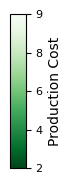

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'clipped_costs' contains the capped production cost values
min_cost = clipped_costs.min()  # Define min_cost based on your capped data
max_cost = clipped_costs.max()  # Define max_cost based on your capped data

# Step 1: Generate the Color Scale Legend
fig, ax = plt.subplots(figsize=(0.2, 2))  # Reduce width of figsize

# Create a color scale based on the Greens_r colormap
cmap = plt.cm.Greens_r
norm = plt.Normalize(vmin=min_cost, vmax=max_cost)

# Create a colorbar with the specified colormap and normalization
colorbar = plt.colorbar(
    plt.cm.ScalarMappable(norm=norm, cmap=cmap),
    cax=ax,
    orientation='vertical'
)

# Set the label for the colorbar with smaller fontsize
colorbar.set_label('Production Cost', fontsize=10)

# Add custom ticks and labels to show specific production cost values
tick_values = np.linspace(min_cost, max_cost, num=5)  # Generate 5 ticks
colorbar.set_ticks(tick_values)  # Set custom ticks

# Format ticks to remove decimals and set smaller fontsize
colorbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))
colorbar.ax.tick_params(labelsize=8)  # Reduce the font size of tick labels

# Save the colorbar as an image
plt.savefig('color_scale_legend.png', bbox_inches='tight')

# Create HTML content for saving
html_content = f"""
<div style="display: flex;">
    <div>{m.to_html()}</div>
    <div><img src="color_scale_legend.png" alt="Color Scale Legend" style="margin-left: 10px;"></div>
</div>
"""

# Save the HTML content to a file
with open("map_with_legend.html", "w") as f:
    f.write(html_content)
